__Необходимо наличие Python, Anaconda и пакета plotly__

В этом задании мы будем использовать данные SOCR по росту и весу 25 тысяч подростков.

In [1]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

from IPython.display import Latex, display

**[1].** Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект *DataFrame*:

In [2]:
data = pd.read_excel('weights_heights.csv')
data = data.drop('Index', axis = 1)
print(data.shape)
data.head()

(25000, 2)


,Height,Weight
0,65.78331,112.9925
1,71.51521,136.4873
2,69.39874,153.0269
3,68.21660,142.3354
4,67.78781,144.2971


**[2].** Постройте 2 раздельные гистограммы распределения роста и веса подростков из выборки *data*.  
Выделите параметры разным цветом и подпишите оси.

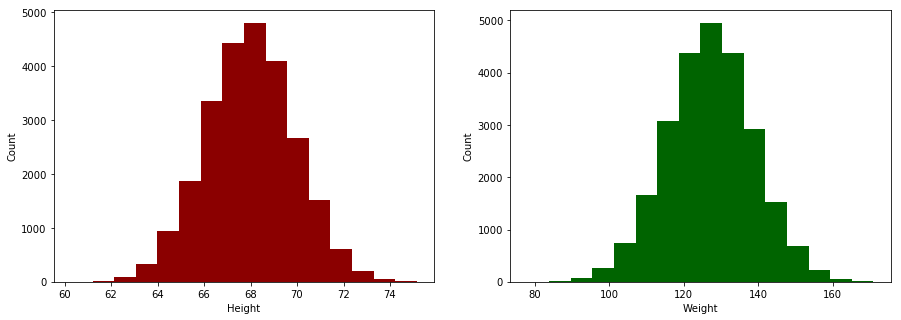

In [3]:
#https://en.wikipedia.org/wiki/Histogram#Sturges.27_formula

sturges_bins = lambda x : 1 + int(np.ceil(np.log2(x)))

plt.figure(figsize = (15, 5))

plt.subplot(121)
plt.hist(data.Height, bins = sturges_bins(data.shape[0]), color = 'darkred')
plt.xlabel('Height')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(data.Weight, bins = sturges_bins(data.shape[0]), color = 'darkgreen')
plt.xlabel('Weight')
plt.ylabel('Count')

plt.show()

**[3.1].** Добавьте третий признак (*'BMI'*). Создайте признак *Индекс массы тела (BMI)*.   
Для этого воспользуйтесь коэффициентами перевода единиц с точностью до 5 знака после запятой.

In [4]:
#Height = дюйм
#Weight = фунт

data['BMI'] = round(0.45 * data.Weight / (2.54/100 * data.Height)**2, 5)
data.head()

,Height,Weight,BMI
0,65.78331,112.9925,18.21224
1,71.51521,136.4873,18.61403
2,69.39874,153.0269,22.16204
3,68.21660,142.3354,21.33427
4,67.78781,144.2971,21.90279


**[3.2].** Постройте картинку, на которой будут отображены попарные зависимости признаков *'Height', 'Weight' и 'BMI'* друг от друга.


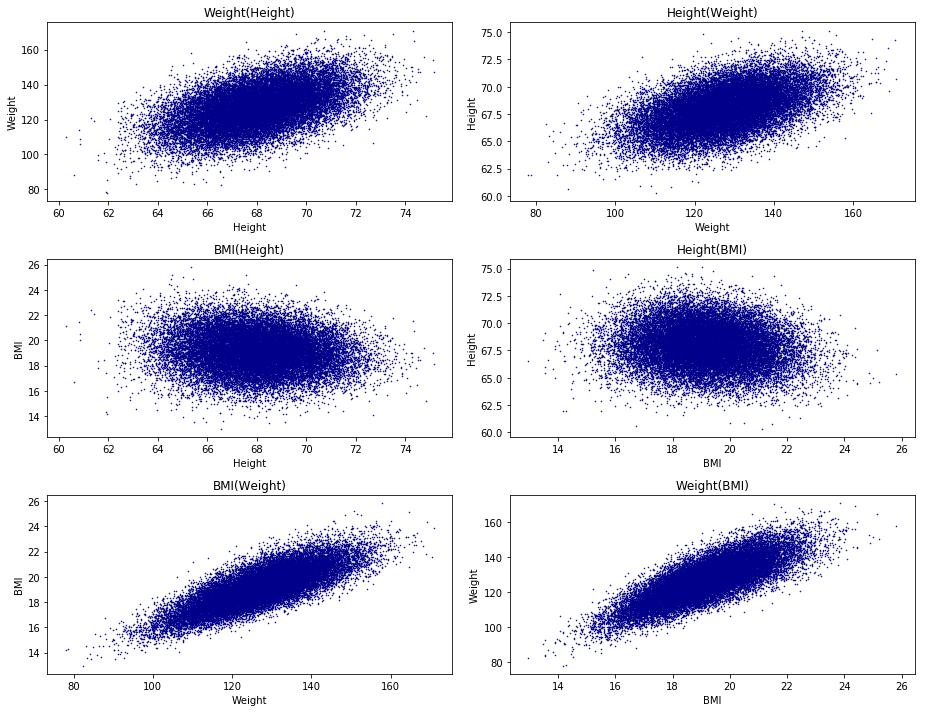

In [5]:
def plot_scatter(subplot, data, colX, colY):
    subplot.scatter(data[colX], data[colY], s = 0.3, color = 'darkblue')
    subplot.set_title(colY +'('+colX+')')
    subplot.set_xlabel(colX)
    subplot.set_ylabel(colY)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (13, 10))
columns = ['Height', 'Weight', 'BMI']
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        plot_scatter(axes[i+j-1, 0], data, columns[i], columns[j])
        plot_scatter(axes[i+j-1, 1], data, columns[j], columns[i])
        
plt.tight_layout()
plt.show()

**[4].** Создайте в *DataFrame data* новый признак **weight_category**, который будет иметь 3 значения:  
1 – если вес меньше 120 фунтов. (~ 54 кг.),  
3 – если вес больше или равен 150 фунтов (~68 кг.),  
2 – в остальных случаях. 

Постройте *boxplot*, демонстрирующий зависимость роста от весовой категории. Подпишите ось $y$ меткой *«Рост»*, ось $x$ – меткой *«Весовая категория»*.

In [6]:
estimate_weight_category = lambda row : 1 if row < 120 else 3 if row > 150 else 2
data['Weight_category'] = [estimate_weight_category(row) for row in data.Weight]

x1 = data.Weight_category[data.Weight_category == 1]
x2 = data.Weight_category[data.Weight_category == 2]
x3 = data.Weight_category[data.Weight_category == 3]

y1 = data.Height[data.Weight_category == 1]
y2 = data.Height[data.Weight_category == 2]
y3 = data.Height[data.Weight_category == 3]

x1_y_data = go.Box( y = y1, x = x1,
                    marker = dict(color = 'darkblue'),
                    name = 'w_category 1')

x2_y_data = go.Box( y = y2, x = x2,
                    marker = dict(color = 'darkred'),
                    name = 'w_category 2')

x3_y_data = go.Box( y = y3, x = x3,
                    marker = dict(color = 'darkgreen'),
                    name = 'w_category 3')

layout = go.Layout(
    yaxis = dict(
        title = 'Рост',
        zeroline = False),
    xaxis = dict(
        title = 'Весовая категория',
        zeroline = False)
)

obj = [x1_y_data, x2_y_data, x3_y_data, ]
fig = go.Figure(data = obj, layout = layout)
plotly.offline.iplot(fig)

**[5].** Постройте *scatter plot* зависимости роста от веса. Подпишите картинку.

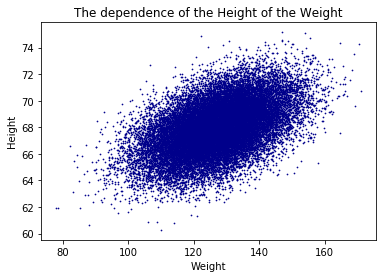

In [7]:
def plot_height_weight_scatter():
    plt.scatter(data['Weight'], data['Height'], s = 0.5, color = 'darkblue')
    plt.title('The dependence of the Height of the Weight')
    plt.xlabel('Weight')
    plt.ylabel('Height')

plot_height_weight_scatter()
plt.show()

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией 
$y = w_0 + w_1 x:$
$$ error(w_0, w_1) = \sum_{i=1}^n(y_i - (w_0 + w_1  x_i))^2 $$
Здесь $n$ - число наблюдений в наборе, $y_i$ и $x_i$ - рост и вес $i$-ого человека в наборе данных.

In [8]:
"""
Params:
    w : tuple of scalar coefs (w0, w1)
    x : 1d-array-like 
    y : 1d-array-like
    #len(x)==len(y)
Returns:
    calculated error
"""
def calculate_error(w, x, y):
    if len(x) != len(y):
        raise ValueError("len of x and y must be identical")
    if len(w) != 2:
        raise ValueError("Must be 2 coeffs")
    return ((y - w[0] - w[1]*x)**2).sum()

**[7].** Проведите на графике из п.**5** две прямые, соответствующие значениям параметров $(w_0, w_1) = (55,\, 0.04)$ и $(w_0, w_1) = (50, \,0.22)$. 

Подпишите оси и график.

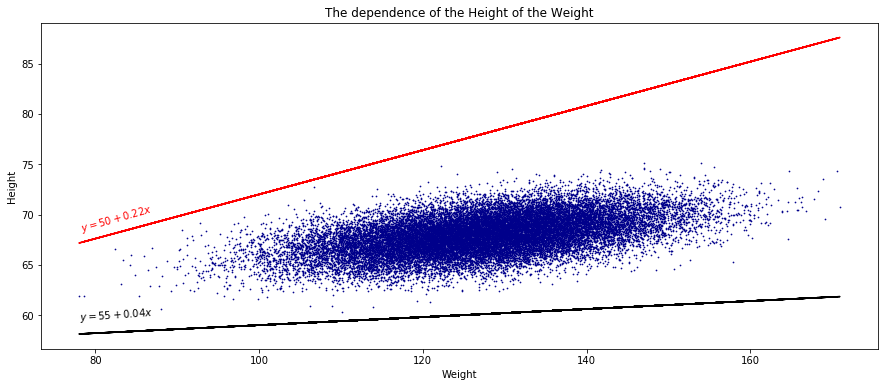

In [9]:
plt.figure(figsize = (15,6))
plot_height_weight_scatter()
plt.plot(data.Weight, 55 + 0.04*data.Weight, 'k-')
plt.text(78, 60, r'$y=55 + 0.04x$', size='medium', weight='bold',  rotation='4')

plt.plot(data.Weight, 50 + 0.22*data.Weight, 'r-')
plt.text(78, 70.3, r'$y=50 + 0.22x$', size='medium', weight='bold',  rotation='15.8', color='red')

plt.show()

**[8].** Постройте график зависимости функции ошибки, посчитанной в п.**6**, от параметра $w_1$ при $w_0 = 50$. 

Подпишите оси и график.

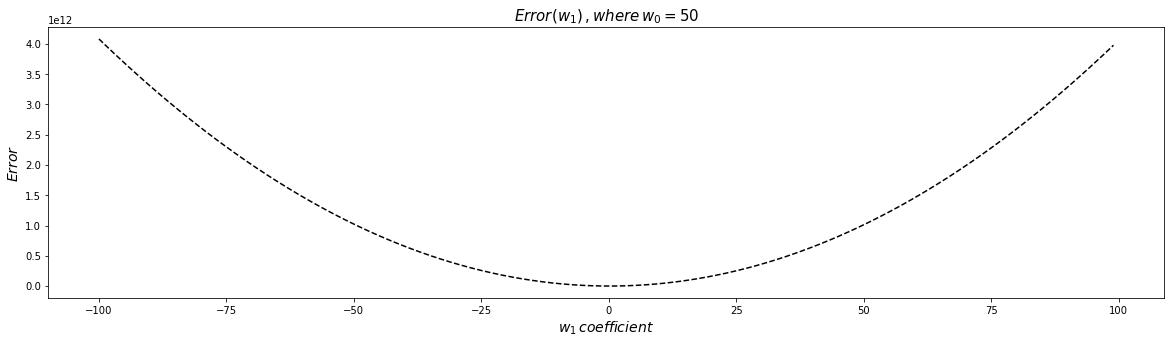

In [14]:
w1_range_fix_w0 = np.arange(-100, 100)
w1_errors = [calculate_error((50, w1), data.Weight, data.Height) for w1 in w1_range_fix_w0]
    
plt.figure(figsize=(20, 5))
plt.plot(w1_range_fix_w0, w1_errors, 'k--')
plt.title(r'$Error(w_1)\, , where \, w_0 = 50$', size = 15)
plt.xlabel(r'$w_1 \, coefficient$', size = 14)
plt.ylabel(r'$Error$', size = 14)
plt.show()

**[9].** Найдите минимум функции, определенной в п.**6**. для значений параметра $w_1$ в диапазоне $[-5, 5]$.

Проведите на графике из п.**5** прямую, соответствующую значениям параметров $(w_0, w_1) = (50,\, w_{1_{opt}})$,  
где $w_{1_{opt}}$ - найденное в п.**8** оптимальное значение параметра $w_1$.

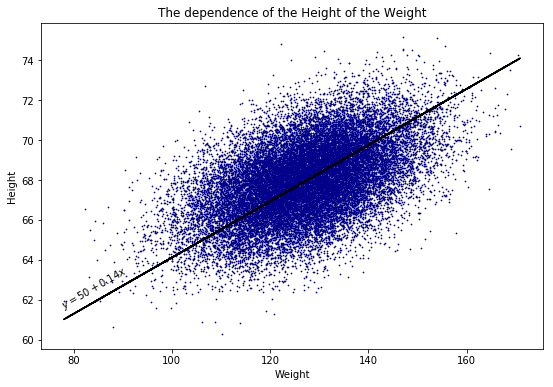

<IPython.core.display.Latex object>

In [15]:
w1_optimize = lambda w1 : calculate_error((50, w1), data.Weight, data.Height)
w1_opt = spo.fmin_tnc(w1_optimize, np.array([0.1]), approx_grad=True, bounds=[(-5, 5)])

plt.figure(figsize = (9,6))
plot_height_weight_scatter()
plt.plot(data.Weight, 50 + w1_opt[0]*data.Weight, 'k-')
plt.text(77, 63.3, r'$y={:d} + {:0.2f}x$'.format(50, w1_opt[0][0]), size='medium', weight='bold',  rotation='30')
plt.show()

display(Latex('Optimal $w_1$ is : {0} '.format(w1_opt[0][0]) + 
              ' with Error : {0}'.format(calculate_error((50, w1_opt[0][0]), data.Weight, data.Height))))

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.**6** от параметров $w_0, w_1$.  
Подпишите ось $x$ меткой *"Intercept"*, ось $y$ - меткой *"Slope"*, а ось $z$ - меткой *"Error"*.

In [16]:
# w0 - intercept - columns,
# w1 - slope - rows
w0_range = np.arange(-100, 100, 2)
w1_range = np.arange(-5, 5, 0.1)
errors = np.array([[calculate_error((w0, w1), data.Weight, data.Height) for w0 in w0_range] for w1 in w1_range])

In [17]:
#http://stackoverflow.com/questions/43747551/change-axis-name-in-box-plotly-python
#That was not easy find this doc
hover_list=[['Intercept: '+'{:0.1f}'.format(w0) +'<br>'+
             'Slope: '    +'{:0.1f}'.format(w1) +'<br>'+
             'Error: '    +'{:0.0f}'.format(errors[j, i]) 
             for i, w0 in enumerate(w0_range)] for j, w1 in enumerate(w1_range)]
    
data_3d = [
    go.Surface(
        x = w0_range,
        y = w1_range,
        z = errors,
        hoverinfo = "text",
        text = hover_list
    )
]

layout = go.Layout(
    title = 'Error(Intercept, Slope)',
    width = 600,
    height = 600,
    scene = dict(
        xaxis = dict(title = 'Intercept'),
        yaxis = dict(title = 'Slope'),
        zaxis = dict(title = 'Error')
    )
)

fig = go.Figure(data=data_3d, layout=layout )
plotly.offline.iplot(fig)

**[11].** Найдите минимум функции, определенной в п.**6**, для значений параметра $w_0$ в диапазоне $[-100, 100]$ и $w_1$- в диапазоне $[-5, 5]$. Начальная точка - $(w_0, w_1) = (0, 0)$. Используйте метод оптимизации алгоритмом *Бройдена-Флетчера-Гольдфарба-Шанно* (а точее, его модификацию с ограниченным использованием памяти в многомерном кубе **L-BFGS-B**).  
Проведите на графике из п.**5** прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

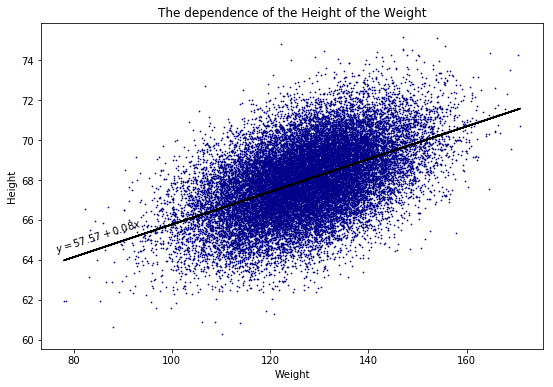

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [18]:
w0_w1_optimize = lambda w : calculate_error((w[0], w[1]), data.Weight, data.Height)
w0_w1_opt = spo.minimize(w0_w1_optimize, np.array([0, 0]), bounds=[(-100, 100), (-5, 5)], method='L-BFGS-B')

plt.figure(figsize = (9, 6))
plot_height_weight_scatter()
y = w0_w1_opt.x[0] + w0_w1_opt.x[1]*data.Weight
plt.plot(data.Weight, y, 'k-')
plt.text(76, 65.7, r'$y={:0.2f} + {:0.2f}x$'.format(w0_w1_opt.x[0], w0_w1_opt.x[1]), 
         size='medium', weight='bold',  rotation='17.4')
plt.show()

display(Latex("Optimal $w_0$ is : {0}".format(w0_w1_opt.x[0])))
display(Latex("Optimal $w_1$ is : {0}".format(w0_w1_opt.x[1])))
display(Latex("Error is : " + str(calculate_error((w0_w1_opt.x[0], w0_w1_opt.x[1]), data.Weight, data.Height))))